##### **Business Understanding**: *Predicting Estimated Time of Arrival (ETA) for Yassir Journeys*
Ride-hailing platforms such as Uber and Yassir operate in a fast-paced environment, relying on real-time data and advanced machine learning algorithms to enhance their services. In particular, accurate prediction of the Estimated Time of Arrival (ETA) for Yassir trips is crucial for improving the reliability and attractiveness of the service to both customers and business partners.

#### **Objectives**
The  goal is to develop a predictive model capable of accurately estimating the time it takes for a Yassir journey to reach its drop-off point. By achieving this objective, Yassir aims to enhance the overall efficiency and quality of its service, providing tangible benefits to both customers and business partners.

#### **Data Understanding**

###### **ID:** A unique identifier associated with each record in your dataset. Each record should have a different ID.

###### **Timestamp:** The date and time when the data was recorded. This can be important for understanding temporal trends or seasonal patterns.

###### **Origin_lat and Origin_lon:** The geographical coordinates (latitude and longitude) of the starting point of each trip.

###### **Destination_lat and Destination_lon:** The geographical coordinates (latitude and longitude) of the destination point of each trip.

###### **Trip_distance:** The distance of the trip in specific units (you should check the unit, for example, in kilometers or miles).

###### **ETA (Estimated Time of Arrival):** The estimated arrival time for each trip in seconds, minutes, or another unit of time

| ID | Timestamp | Origin_lat | Origin_lon | Destination_lat | Destination_lon | Trip_distance | ETA |
|----|-----------|------------|------------|------------------|------------------|---------------|-----|
|Unique| Date| latitude | longitude | destinatination lat | destination long | Trip distance | ETA |


#### **Package imports**

In [32]:
#%pip install geopandas matplotlib folium


In [33]:
import pandas as pd
import numpy as np
import pylab as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn import cluster
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn import pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from datetime import datetime as dt , time , date
import datetime
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
%matplotlib inline

#### *Data Loading*

In [34]:
# load training
training = pd.read_csv('data/Train.csv').set_index('ID')
training['Timestamp'] = pd.to_datetime(training['Timestamp'])
training.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA
ID,,,,,,,
000FLWA8,2019-12-04 20:01:50+00:00,3.26,36.78,3.00,36.72,39627,2784
000RGOAM,2019-12-10 22:37:09+00:00,3.09,36.71,3.08,36.73,3918,576
001QSGIH,2019-11-23 20:36:10+00:00,3.14,36.74,3.09,36.74,7265,526
002ACV6R,2019-12-01 05:43:21+00:00,3.24,36.78,3.05,36.76,23350,3130
0039Y7A8,2019-12-17 20:30:20+00:00,2.91,36.71,3.21,36.70,36613,2138


In [35]:
# testing data
testing = pd.read_csv('data/Test.csv').set_index('ID')
testing['Timestamp'] = pd.to_datetime(testing['Timestamp'])
testing.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance
ID,,,,,,
000V4BQX,2019-12-21 05:52:37+00:00,2.98,36.69,2.98,36.75,17549
003WBC5J,2019-12-25 21:38:53+00:00,3.03,36.77,3.07,36.75,7532
004O4X3A,2019-12-29 21:30:29+00:00,3.04,36.71,3.01,36.76,10194
006CEI5B,2019-12-31 22:51:57+00:00,2.90,36.74,3.21,36.70,32768
009G0M2T,2019-12-28 21:47:22+00:00,2.86,36.69,2.83,36.70,4513


In [36]:
# weather data
weather_df = pd.read_csv('data/Weather.csv')
weather_df.head()

,date,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m
0,2019-11-01,290.63,296.43,294.13,"101,853.62",292.50,"100,806.35",0.00,3.56,0.94
1,2019-11-02,289.14,298.43,295.55,"101,225.16",293.34,"100,187.25",0.00,5.32,3.26
2,2019-11-03,287.67,296.61,295.18,"100,806.62",293.67,"99,771.41",0.00,8.45,3.17
3,2019-11-04,287.63,297.17,294.37,"101,240.93",292.38,"100,200.84",0.00,5.99,2.24
4,2019-11-05,286.41,294.28,292.50,"101,131.75",289.14,"100,088.50",0.00,6.96,2.66


Exploratory Data Analysis: EDA


In [37]:
#Train 
training.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83924 entries, 000FLWA8 to ZZZY11ZN
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   Timestamp        83924 non-null  datetime64[ns, UTC]
 1   Origin_lat       83924 non-null  float64            
 2   Origin_lon       83924 non-null  float64            
 3   Destination_lat  83924 non-null  float64            
 4   Destination_lon  83924 non-null  float64            
 5   Trip_distance    83924 non-null  int64              
 6   ETA              83924 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(4), int64(2)
memory usage: 5.1+ MB


In [38]:
training.shape

(83924, 7)

In [39]:
#let's check if we are missing value
training.isna().sum()

Timestamp          0
Origin_lat         0
Origin_lon         0
Destination_lat    0
Destination_lon    0
Trip_distance      0
ETA                0
dtype: int64

we are not a missing values

In [40]:
# format numerical columns to 2 decimal places with comma separator
pd.options.display.float_format = '{:,.2f}'.format

# statistics for numerical columns
training.describe()

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA
count,"83,924.00","83,924.00","83,924.00","83,924.00","83,924.00","83,924.00"
mean,3.05,36.74,3.06,36.74,"13,527.82","1,111.70"
std,0.10,0.03,0.10,0.03,"9,296.72",563.57
min,2.81,36.59,2.81,36.60,1.00,1.00
25%,2.99,36.72,3.00,36.72,"6,108.00",701.00
50%,3.05,36.74,3.05,36.74,"11,731.50","1,054.00"
75%,3.10,36.76,3.11,36.76,"19,369.00","1,456.00"
max,3.38,36.82,3.38,36.82,"62,028.00","5,238.00"


***Origin_lat and Destination_lat*:**
The values appear to be centered around 3.05, with a relatively low standard deviation of 0.10.
The minimum and maximum values show a limited range.

***Origin_lon and Destination_lon*:**
The values seem to be centered around 36.74, with a relatively low standard deviation of 0.03.
The minimum and maximum values show a limited range.

***Trip_distance*:**
The average trip distance is approximately 13,527.82, with a significant variability indicated by a high standard deviation of 9,296.72.
The minimum distance is 1.00, and the maximum distance is 62,028.00.

***ETA (Estimated Time of Arrival)*:**
The mean ETA is around 1,111.70, with a standard deviation of 563.57.
ETA varies from 1.00 to 5,238.00.

Univariate Analysis

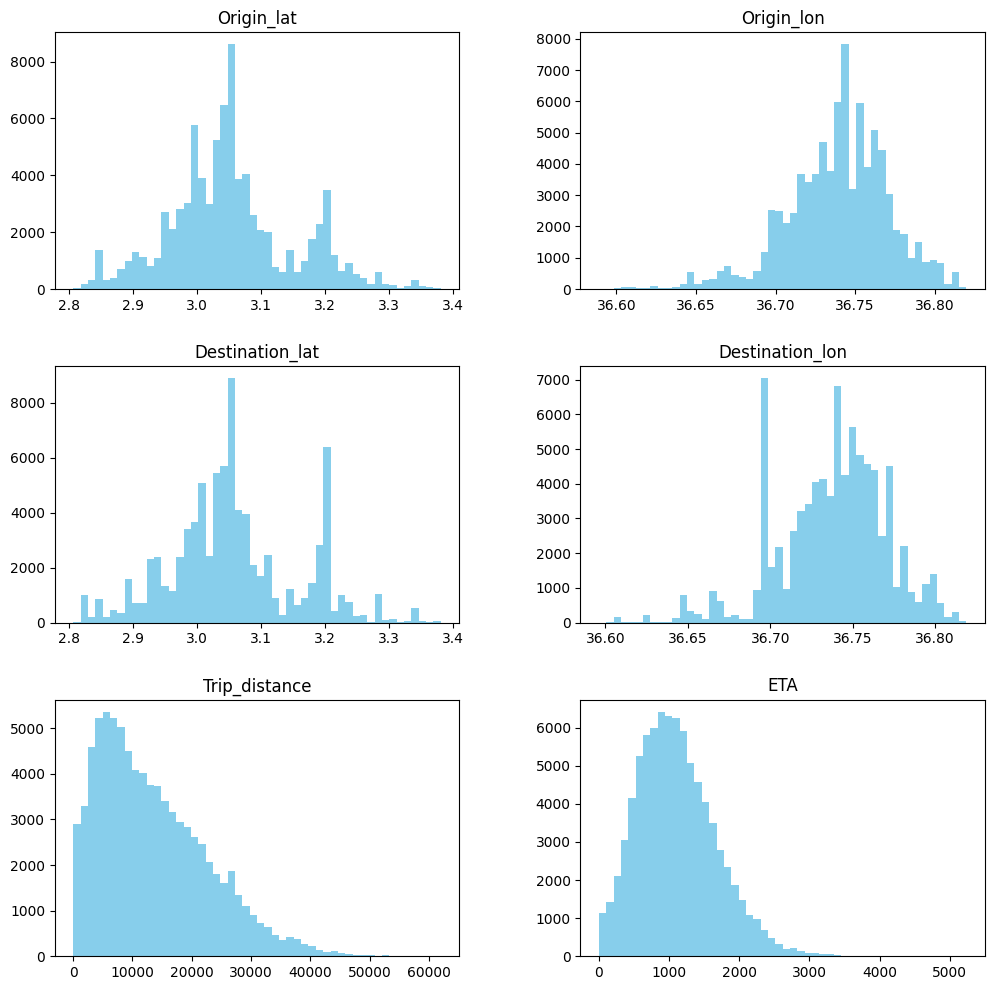

In [41]:
# Exclude the 'timestamp' time column
selected_columns = training.drop(columns=['Timestamp'])

# Create histograms for the remaining variables
selected_columns.hist(figsize=(12, 12), grid=False, bins=50, color='skyblue')
plt.show()



The origin and destination points seem to be in the same coordinates, indicating that the majority of the trips are likely within a single geographic area. This concentration of data in a specific zone is likely associated with internal activity within a country, potentially representing a dense urban area or a hub of economic activity.

C:\Users\AD\AppData\Local\Temp\ipykernel_1992\3680603892.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


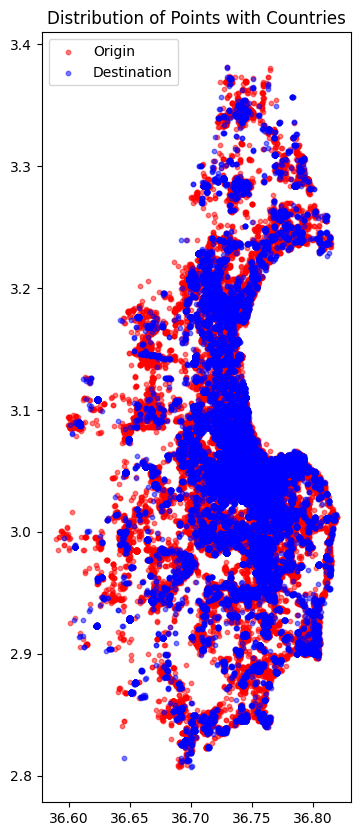

In [42]:
# Create a GeoDataFrame based on the origin coordinates
geometry_origin = [Point(lon, lat) for lon, lat in zip(selected_columns['Origin_lon'], selected_columns['Origin_lat'])]
gdf_origin = gpd.GeoDataFrame(selected_columns, geometry=geometry_origin, crs='EPSG:4326')

# Create a GeoDataFrame based on the destination coordinates
geometry_destination = [Point(lon, lat) for lon, lat in zip(selected_columns['Destination_lon'], selected_columns['Destination_lat'])]
gdf_destination = gpd.GeoDataFrame(selected_columns, geometry=geometry_destination, crs='EPSG:4326')

# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Display the world map
fig, ax = plt.subplots(figsize=(15, 10))

# Uncomment the line below if you want to plot world boundaries
# world.boundary.plot(ax=ax, linewidth=1)
ax.set_title('Distribution of Points with Countries')

# Overlay the origin and destination points
gdf_origin.plot(ax=ax, color='red', markersize=10, alpha=0.5, label='Origin')
gdf_destination.plot(ax=ax, color='blue', markersize=10, alpha=0.5, label='Destination')

# Add a legend
plt.legend()

plt.show()


the visualization of the map indeed confirms the concentration of data within a specific geographic area. The proximity of the origin and destination points, along with the clustering observed on the map, aligns with the interpretation of strong local activity.

### Multi Variate

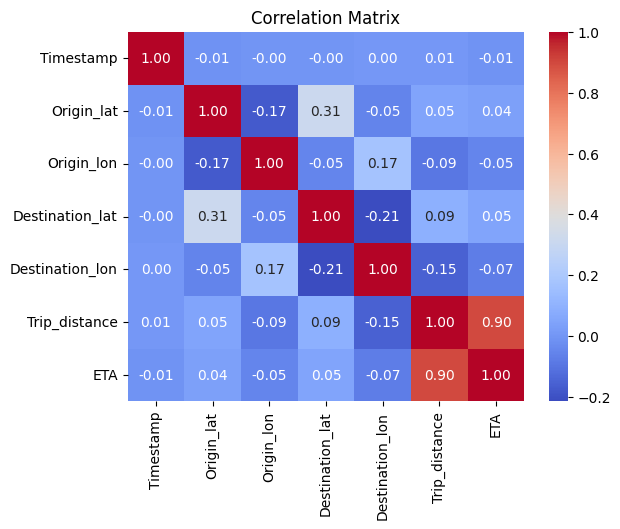

In [52]:
# Create a correlation matrix for continuous variables
correlation_matrix = training.corr()

# Display the correlation matrix with a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

# Add a title
plt.title('Correlation Matrix')

# Display the plot
plt.show()


The correlation matrix indicates a significant correlation between the trip distance ("Trip_distance") and the estimated time of arrival ("ETA"). This strong correlation suggests a linear relationship between these two variables: as the trip distance increases, the estimated time of arrival also tends to increase. This aligns with the intuition that longer trips typically require more time to be covered.

c:\Users\AD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\AD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\AD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\AD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

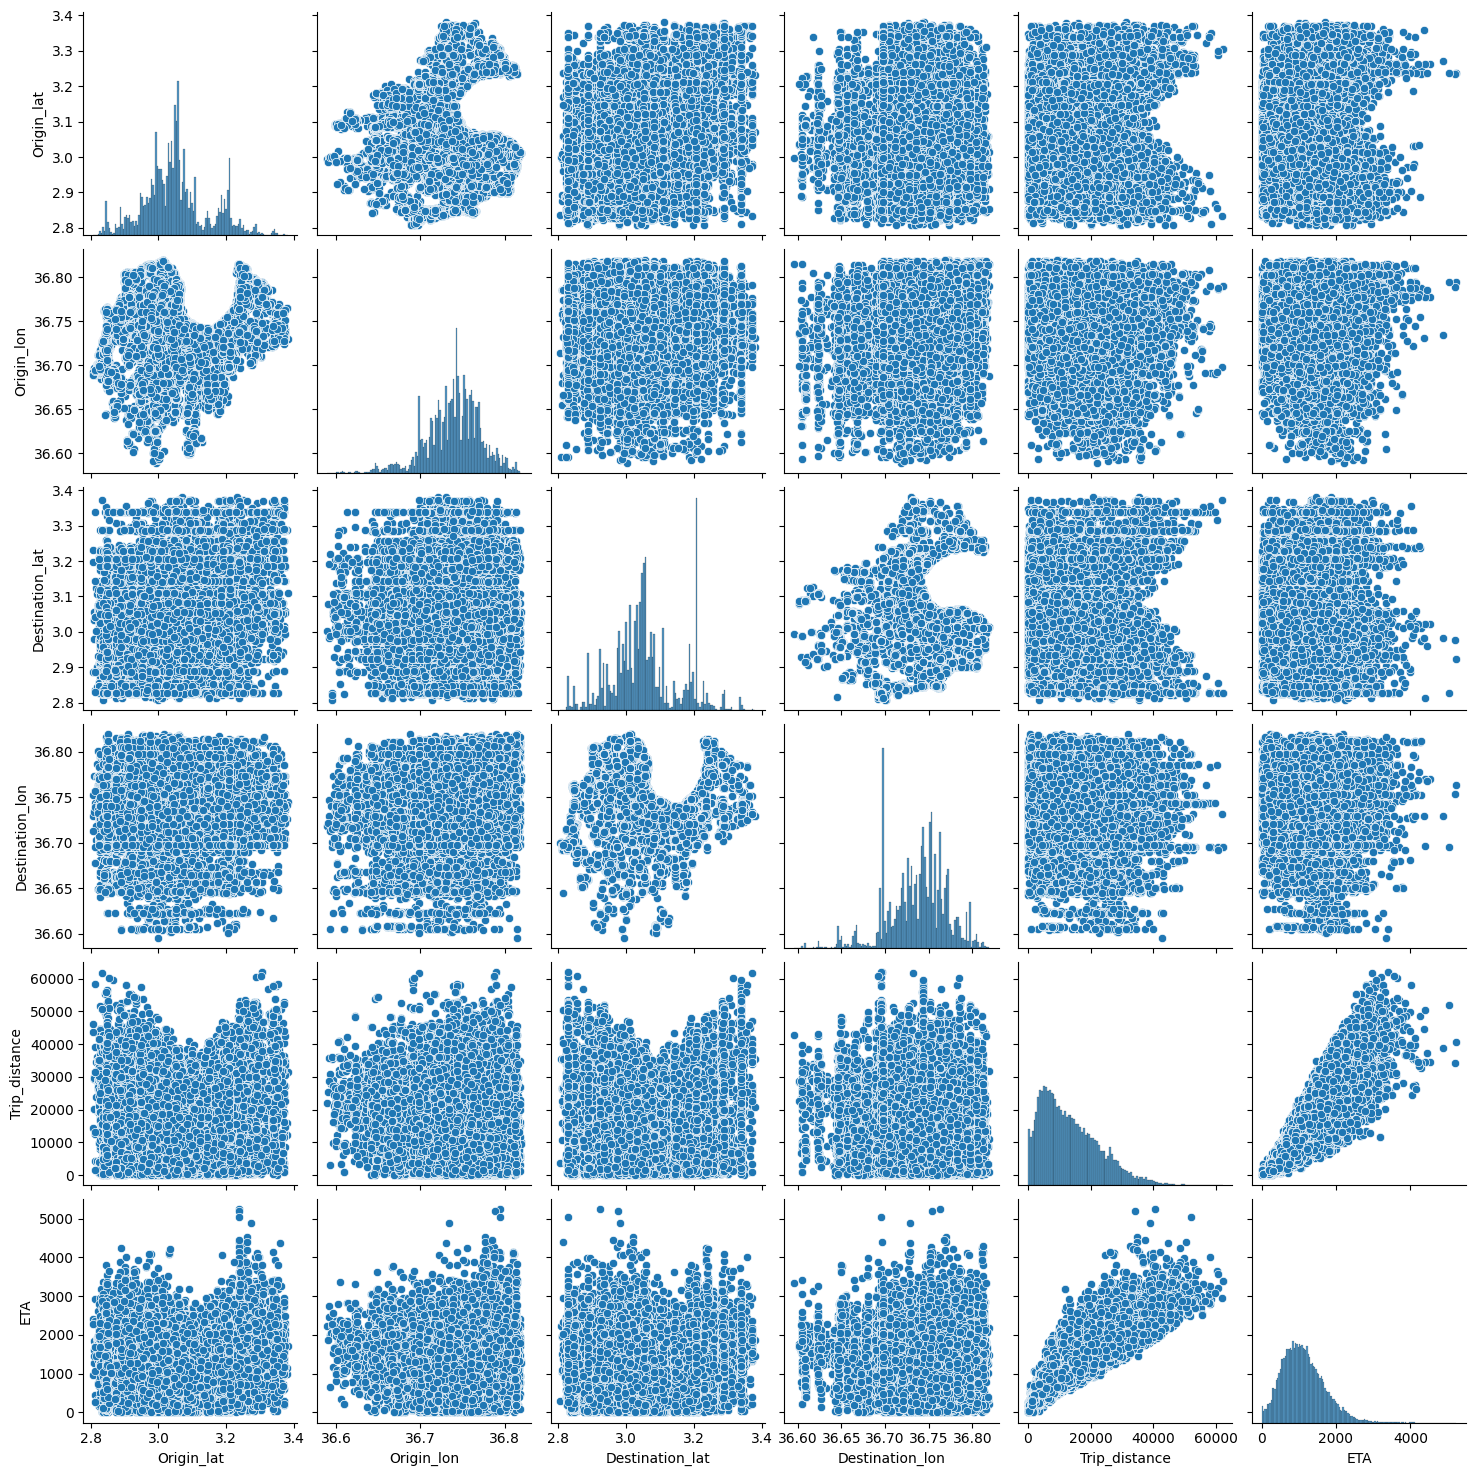

In [51]:
# Pair plot for variables continues
sns.pairplot(training)
plt.show()


Bi-variate ETA Trip_Distance 

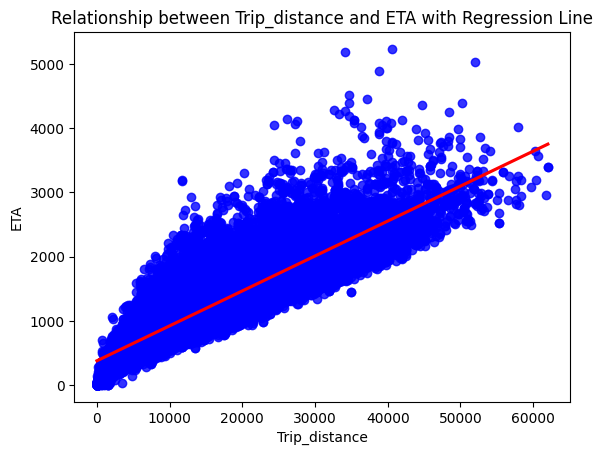

In [55]:
# Scatter plot with regression line
sns.regplot(x='Trip_distance', y='ETA', data=gdf_origin, scatter_kws={'color':'blue'}, line_kws={'color':'red'})

# Set x-axis label
plt.xlabel('Trip_distance')

# Set y-axis label
plt.ylabel('ETA')

# Set plot title
plt.title('Relationship between Trip_distance and ETA with Regression Line')

# Show the plot
plt.show()


The analysis of the relationship between the trip distance ('Trip_distance') and the estimated time of arrival ('ETA') indicates a significant correlation, suggesting a linear trend where longer trip distances are associated with longer arrival times. However, the presence of points deviating from the regression line suggests some variability and the possibility of atypical observations.

In [56]:
# Création de la colonne vitesse
training['Speed'] = training['Trip_distance'] / training['ETA']


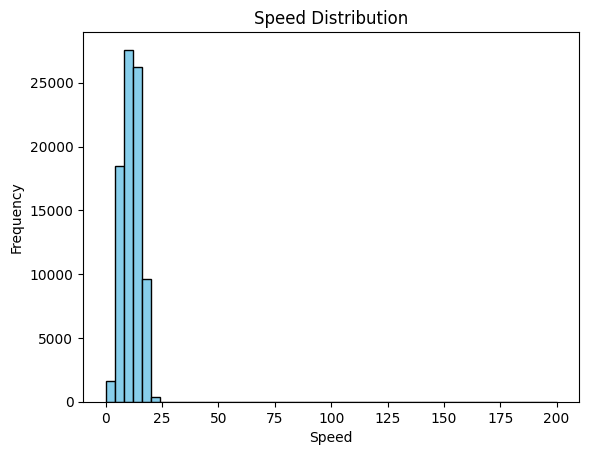

In [68]:
# Histogram of the speed column with x-axis limit
plt.hist(training['Speed'], bins=50, color='skyblue', edgecolor='black', range=[0, 200])
plt.title('Speed Distribution')
plt.xlabel('Speed')
plt.ylabel('Frequency')
plt.show()


We observe a concentration of speed between 0 and 20, indicating that most observations have speeds within this range. This suggests that the majority of trips in our dataset occur at relatively low speeds.

Merge Train and Weather 

In [ ]:
# Perform the merge on the "date" column
merged_data = pd.merge(training, weather_df, on='date', how='left')

# Display the first few rows of the merged DataFrame
print(merged_data.head())